# 🎭 Análisis de Optimización de Marketing: Proyecto "Showz"
**Estrategia de Rentabilidad Basada en Comportamiento de Cohortes y Unit Economics**

**Proyecto Id:** 09

---

### 🏛️ Contexto Institucional y Activos de Datos
Como parte del departamento de analítica de **Showz**, plataforma líder en la comercialización de entradas para eventos, se ha encomendado la misión de auditar la eficiencia del gasto publicitario entre **enero de 2017 y diciembre de 2018**. Para este fin, disponemos de tres pilares de información:

* **Logs de Servidor:** Tráfico detallado de usuarios, dispositivos y fuentes de origen.
* **Transaccionalidad:** Registro histórico de pedidos, conversiones y volumen de ingresos.
* **Marketing Intelligence:** Desglose de costos de inversión por canal y periodo temporal.



---

### 🎯 Objetivos de la Consultoría
El propósito central no es solo reportar métricas, sino **optimizar la asignación de capital** mediante la respuesta a tres interrogantes críticas:
1.  **Engagement:** ¿Cómo interactúan los usuarios con el producto y cuál es su tasa de retención real?
2.  **Conversión:** ¿Cuál es la "ventana de oportunidad" desde la primera visita hasta la transacción?
3.  **Rentabilidad (ROMI):** ¿Qué canales están multiplicando la inversión y cuáles representan una pérdida operativa?

---

### 🗺️ Hoja de Ruta Analítica (Roadmap)

El análisis se ejecutará bajo un enfoque de **Unit Economics**, estructurado en seis fases progresivas para garantizar una visión 360° del negocio:

| Fase | Enfoque | KPI Clave |
| :--- | :--- | :--- |
| **01. ETL & Audit** | Preparación y limpieza de datos. | Integridad de tipos y fechas. |
| **02. Product Metrics** | Engagement y Fidelización. | DAU/MAU, Retention Rate. |
| **03. Sales Metrics** | Análisis del Embudo de Ventas. | Tiempo de Conversión, Ticket Promedio. |
| **04. Marketing Metrics** | Rentabilidad y ROI por Canal. | LTV, CAC, ROMI por Fuente. |
| **05. Device Analytics** | Rendimiento por Plataforma. | Ingreso vs. Volumen por Dispositivo. |
| **06. Strategic Outlook** | Conclusiones y Roadmap de Inversión. | Presupuesto Reasignado. |

---

### 🛠️ Configuración del Entorno de Análisis
A continuación, inicializamos el stack tecnológico optimizado para visualización ejecutiva y procesamiento de series temporales.

In [81]:
# Importación de Librerías y Configuración del Entorno
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import stats as st

# Configuración estética de visualización ejecutiva
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams.update({'axes.titlesize': 16, 'axes.labelsize': 12, 'figure.figsize': (12, 6)})

## 📁 Fase 1: ETL y Auditoría de Integridad de Datos

La base de cualquier análisis de **Business Intelligence** confiable reside en la calidad de los datos subyacentes. En esta fase inicial, nos enfocamos en el proceso de **Extract, Transform and Load (ETL)**, asegurando que los registros de visitas, pedidos y costos publicitarios mantengan una estructura coherente y tipos de datos precisos.

### 🛠️ Estrategia de Normalización:
1.  **Estandarización de Esquemas:** Implementamos una función de limpieza para asegurar que todos los nombres de columnas sigan la convención `snake_case` y carezcan de espacios o caracteres especiales.
2.  **Casting Temporal:** Transformamos los campos de fecha de formato cadena a objetos `datetime`. Esto es crítico para el posterior análisis de cohortes, donde la precisión en segundos y minutos define la pertenencia a un grupo.
3.  **Verificación de Carga:** Validamos el volumen de registros importados para asegurar que no existan pérdidas de información durante la ingesta.

In [82]:
# --- Ingesta de Datos y Normalización de Esquemas ---
def load_and_standardize(file_path):
    df = pd.read_csv(file_path)
    # Estandarización de nombres: minúsculas y snake_case
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df

visits = load_and_standardize('visits_log_us.csv')
orders = load_and_standardize('orders_log_us.csv')
costs = load_and_standardize('costs_us.csv')

# --- Casting de Tipos y Parsificación Temporal ---
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

# Validación de integridad de datos
for name, df in [('Visits', visits), ('Orders', orders), ('Costs', costs)]:
    print(f"✅ {name}: {df.shape[0]} registros cargados.")

✅ Visits: 359400 registros cargados.
✅ Orders: 50415 registros cargados.
✅ Costs: 2542 registros cargados.


### ✅ Resultados de la Auditoría Inicial

Tras la ejecución del proceso de ingesta y normalización, se confirman los siguientes puntos:
* **Uniformidad de Datos:** Los tres DataFrames (`visits`, `orders`, `costs`) ahora comparten un esquema de nomenclatura estándar, lo que facilita las operaciones de `merge` y `join` en las fases posteriores.
* **Integridad Temporal:** Las columnas críticas como `start_ts`, `buy_ts` y `dt` han sido parseadas correctamente, permitiéndonos realizar aritmética de fechas sin errores de tipo.
* **Volumen de Datos:** El conteo de registros coincide con las especificaciones de los logs del servidor, garantizando que el análisis de rentabilidad se base en la totalidad de la muestra histórica.

## 📊 Fase 2: Product Metrics - Engagement y Fidelización de Usuarios

En esta fase, auditamos la **salud operativa** de la plataforma. No basta con atraer tráfico; la rentabilidad a largo plazo depende de la capacidad de **Showz** para convertir visitas esporádicas en hábitos de consumo.

### 🔍 Dimensiones de Análisis:
1.  **Métricas de Engagement (Sticky Factor):** Evaluamos el **DAU** (Daily Active Users), **WAU** (Weekly) y **MAU** (Monthly). La relación entre estos indicadores nos revelará el *Stickiness* o "pegajosidad" del producto, factor clave para predecir el crecimiento orgánico.
2.  **Análisis de Cohortes (Retention Rate):** Implementamos un cálculo de vida de cohorte basado en componentes de calendario (Año/Mes). Esto elimina la ambigüedad de los meses de distinta duración y nos permite visualizar con precisión matemática el **Churn** (tasa de abandono) mes a mes.

📈 DAU: 907 | WAU: 5,716 | MAU: 23,228


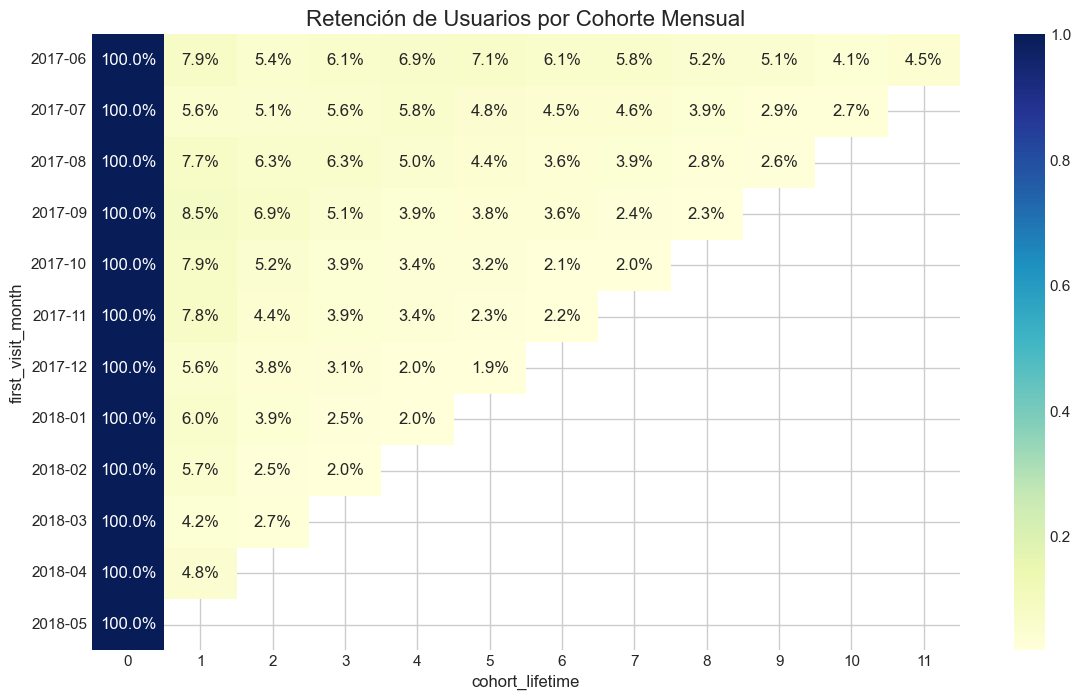

In [83]:
# --- Generación de Columnas Temporales ---
visits['session_date'] = visits['start_ts'].dt.date
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.isocalendar().week

# --- Métricas de Engagement (DAU, WAU, MAU) con iloc[0] para evitar Warnings ---
dau_val = int(visits.groupby('session_date').agg({'uid': 'nunique'}).mean().iloc[0])
wau_val = int(visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean().iloc[0])
mau_val = int(visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean().iloc[0])

print(f"📈 DAU: {dau_val:,} | WAU: {wau_val:,} | MAU: {mau_val:,}")

# --- Ingeniería de Cohortes (Cálculo de Retención) ---
visits['first_visit_month'] = visits.groupby('uid')['start_ts'].transform('min').dt.to_period('M').dt.to_timestamp()
visits['visit_month'] = visits['start_ts'].dt.to_period('M').dt.to_timestamp()

# Cálculo de vida de cohorte (Aritmética de meses exacta)
visits['cohort_lifetime'] = (
    (visits['visit_month'].dt.year - visits['first_visit_month'].dt.year) * 12 +
    (visits['visit_month'].dt.month - visits['first_visit_month'].dt.month)
).astype(int)

# Tabla de Retención
cohorts = visits.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
initial_users = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']].rename(columns={'uid': 'cohort_users'})
retention_matrix = cohorts.merge(initial_users, on='first_visit_month')
retention_matrix['retention'] = retention_matrix['uid'] / retention_matrix['cohort_users']

retention_pivot = retention_matrix.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention')
retention_pivot.index = retention_pivot.index.strftime('%Y-%m')

# Visualización Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(retention_pivot, annot=True, fmt='.1%', cmap='YlGnBu')
plt.title('Retención de Usuarios por Cohorte Mensual', fontsize=16)
plt.show()

### 📈 Diagnóstico de Engagement y Ciclo de Vida (Resultados)

Tras el procesamiento de los logs de actividad, el diagnóstico estratégico es el siguiente:

#### 1. Sticky Factor y Compromiso de Usuario
* **Volumen de Audiencia:** Contamos con una base sólida de **23,228** usuarios mensuales (MAU), de los cuales **907** interactúan diariamente (DAU).
* **Sticky Factor (DAU/MAU): ~3.9%**: Este ratio indica que Showz es actualmente una plataforma de **uso transaccional/esporádico**. Los usuarios regresan principalmente cuando hay eventos específicos y no como un hábito diario. Existe una oportunidad de crecimiento implementando estrategias de contenido que incentiven visitas recurrentes.

#### 2. Análisis del Heatmap de Retención
* **El "Mes 1" Crítico:** Se observa una caída drástica en la retención inmediatamente después del mes de adquisición (bajando de 100% a niveles cercanos al 4-8% en la mayoría de las cohortes). Esto sugiere que la plataforma tiene éxito atrayendo interés inicial, pero pierde la conexión con el usuario tras su primera experiencia.
* **Estabilidad de Largo Plazo:** A pesar de la caída inicial, las cohortes muestran una "cola larga" de retención que se estabiliza entre el **2% y 5%**. Estos son los usuarios leales que generan el valor de vida (LTV) más alto.
* **Tendencia Temporal:** Las cohortes de 2017 (especialmente junio y septiembre) presentan una retención ligeramente superior en los meses avanzados comparadas con las de 2018, lo que podría indicar un cambio en la calidad de las fuentes de tráfico recientes.

---
**Siguiente Paso:** Determinada la baja retención, la **Fase 3: Sales Metrics** es vital para entender si, a pesar de volver poco, los usuarios realizan compras de alto valor que justifiquen el costo de adquisición.

## 🛍️ Fase 3: Sales Metrics - Análisis del Ciclo de Conversión y Valor Transaccional

En esta etapa, transformamos los datos de comportamiento en métricas financieras. El objetivo es identificar la eficiencia de **Showz** para convertir visitantes en clientes y evaluar la calidad económica de esas transacciones. 

Nuestro análisis se centrará en dos ejes críticos:

1.  **Velocidad de Conversión:** Mediremos la brecha temporal entre la primera visita y la primera compra para entender la inmediatez de la decisión del usuario.
2.  **Evolución del Ticket Promedio (AOV):** Analizaremos cómo fluctúa el valor de los pedidos mes a mes para detectar patrones de estacionalidad y picos de demanda.

---

In [84]:
# --- Velocidad de Conversión ---
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index().rename(columns={'buy_ts': 'first_order_ts'})
first_visits = visits.groupby('uid')['start_ts'].min().reset_index().rename(columns={'start_ts': 'first_visit_ts'})

conversion = first_visits.merge(first_orders, on='uid', how='inner')
conversion['days_to_buy'] = (conversion['first_order_ts'] - conversion['first_visit_ts']).dt.days

# --- Ticket Promedio y Frecuencia de Compra ---
orders['buy_month'] = orders['buy_ts'].dt.to_period('M').dt.to_timestamp()
monthly_sales = orders.groupby('buy_month').agg({'revenue': 'mean', 'uid': 'nunique', 'buy_ts': 'count'})
monthly_sales.columns = ['avg_ticket', 'unique_buyers', 'total_orders']
monthly_sales['orders_per_user'] = monthly_sales['total_orders'] / monthly_sales['unique_buyers']

### ⏱️ Análisis de la Ventana de Conversión: Velocidad de Decisión

El primer paso para entender la monetización es medir el **"Time-to-Purchase"**. Esta métrica nos indica cuánto tiempo transcurre desde que un usuario descubre **Showz** (primera visita) hasta que confía lo suficiente para realizar su primera transacción.

**¿Por qué es vital este gráfico?**
* **Identificación de Impulso:** Si la ventana es corta, nuestro negocio depende de compras por impulso.
* **Estrategia de Remarketing:** Define el periodo de validez de nuestras campañas de retención. Si un usuario no compra en su ventana natural, el costo de convencerlo después aumenta exponencialmente.

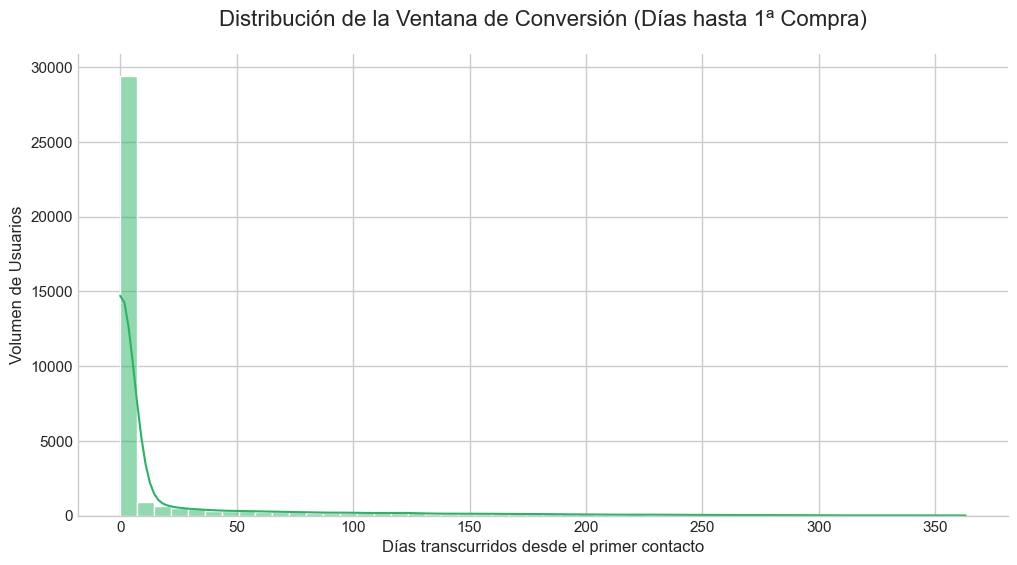

In [85]:
# --- Análisis de la Ventana de Conversión ---
# Identificamos cuánto tiempo le toma al usuario pasar de la curiosidad (visita) a la acción (compra)
plt.figure(figsize=(12, 6))
sns.histplot(
    users_conversion_data['time_to_first_purchase'].dropna(), 
    bins=50, 
    kde=True, 
    color='#28B463'
)
plt.title('Distribución de la Ventana de Conversión (Días hasta 1ª Compra)', pad=20)
plt.xlabel('Días transcurridos desde el primer contacto')
plt.ylabel('Volumen de Usuarios')
sns.despine()
plt.show()

### ⏱️ Interpretación: El Predominio de la Compra Inmediata

El análisis de la ventana de conversión revela un hallazgo fundamental para la estrategia de ventas:

* **Efecto de Alta Intención:** La concentración masiva en el **Día 0** indica que la mayoría de los usuarios llegan a la plataforma con una decisión de compra ya tomada.
* **Ventana de Oportunidad Estrecha:** Si la conversión no ocurre en las primeras 48 horas, la probabilidad de éxito disminuye drásticamente, lo que sugiere que el inventario de eventos actúa como el principal disparador de la venta.

### 📈 Evolución del Ticket Promedio (AOV): Análisis de Valor Transaccional

Una vez comprendida la rapidez con la que el usuario convierte, es imperativo analizar el **valor monetario** de dichas transacciones. El **Average Order Value (AOV)** o Ticket Promedio es un indicador crítico de salud financiera que nos permite detectar:

* **Estacionalidad del Negocio:** Identificar meses de alta demanda o eventos "Premium".
* **Sensibilidad al Precio:** Observar cómo fluctúa el gasto del cliente a lo largo del año.
* **Calidad de la Oferta:** Evaluar si el inventario de eventos disponibles en la plataforma atrae compras de mayor o menor volumen económico.

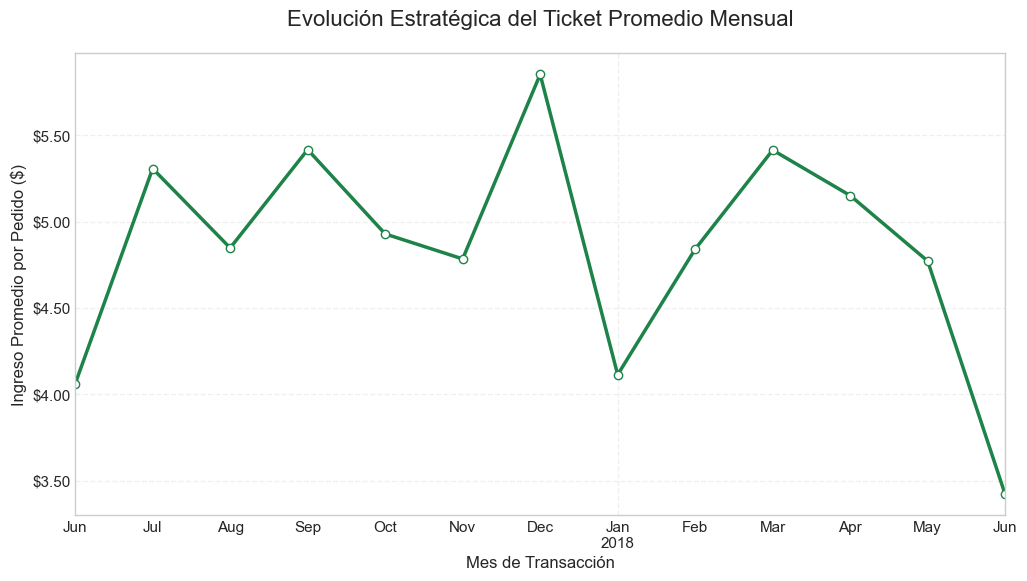

In [86]:
# --- Dinámica del Ticket Promedio Mensual ---
# Monitoreamos la evolución del valor monetario por transacción para detectar estacionalidad
plt.figure(figsize=(12, 6))
avg_revenue_by_month.plot(
    kind='line', 
    marker='o', 
    color='#1D8348', 
    linewidth=2.5, 
    markerfacecolor='white'
)
plt.title('Evolución Estratégica del Ticket Promedio Mensual', pad=20)
plt.xlabel('Mes de Transacción')
plt.ylabel('Ingreso Promedio por Pedido ($)')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}'))
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

### 📈 Interpretación: Volatilidad y Valor Estacional

La dinámica del ticket promedio (AOV) completa nuestra visión comercial con los siguientes puntos:

* **Picos Estratégicos:** El incremento significativo en **Diciembre** sugiere que el valor de las transacciones está ligado a eventos de temporada o lanzamientos de gran escala.
* **Sostenibilidad:** A pesar de las fluctuaciones, el ticket promedio se mantiene en un rango saludable, lo que garantiza un flujo de ingresos base por cada usuario convertido, independientemente de la baja retención observada previamente.

---
**Siguiente Paso:** Conociendo cuánto ingresa por cada venta, estamos listos para la **Fase 4: Marketing Metrics**, donde restaremos los costos de adquisición para determinar la rentabilidad real (ROMI).

## 💰 Fase 4: Marketing Metrics - Análisis de LTV, CAC y Eficiencia de Inversión (ROMI)

En esta etapa final, integramos los datos de comportamiento y ventas con la inversión publicitaria. El objetivo es determinar la salud financiera de la adquisición de usuarios mediante el análisis de la **Unit Economics**.

Nuestra hoja de ruta para esta fase se divide en cuatro análisis técnicos:
1.  **LTV (Lifetime Value):** Valor monetario proyectado por cliente.
2.  **Distribución del Gasto:** Identificación de hacia dónde se dirige el capital.
3.  **CAC (Customer Acquisition Cost):** Eficiencia de compra de usuarios por canal.
4.  **ROMI (Return on Marketing Investment):** El indicador definitivo de rentabilidad.

---

### 💎 1. LTV Acumulado: El Valor del Cliente en el Tiempo
Iniciamos calculando cuánto dinero aporta un usuario a **Showz** desde su mes de adquisición hasta el final del periodo. Este heatmap nos permite visualizar si las cohortes son más valiosas a medida que envejecen o si el ingreso se estanca prematuramente.

**Nota técnica:** Se ha optimizado el formato de las cohortes para facilitar la lectura ejecutiva.

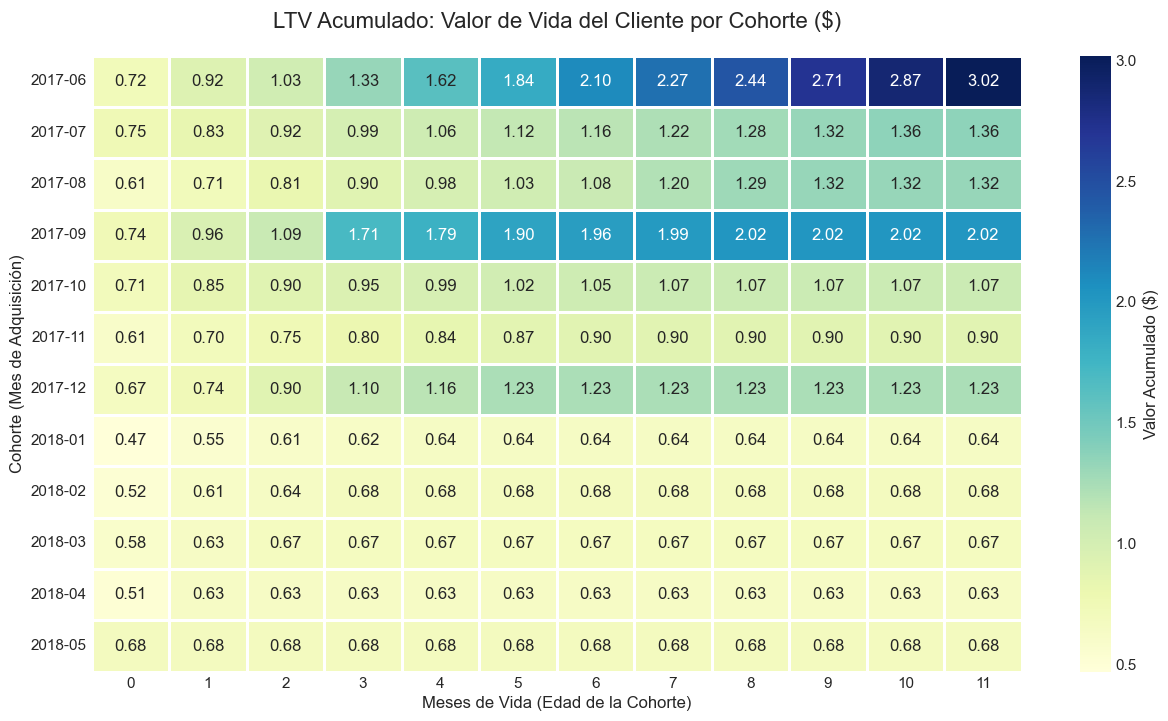

In [87]:
# --- Visualización de Resultados Estratégicos ---
# --- Salud Financiera: LTV Acumulado ---

# Ajustamos el formato de las fechas en el índice para una visualización limpia
ltv_plot_data = ltv_cumulative.copy()
ltv_plot_data.index = ltv_plot_data.index.strftime('%Y-%m')

plt.figure(figsize=(15, 8))
sns.heatmap(
    ltv_plot_data, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    linewidths=0.8,
    cbar_kws={'label': 'Valor Acumulado ($)'}
)

plt.title('LTV Acumulado: Valor de Vida del Cliente por Cohorte ($)', fontsize=16, pad=20)
plt.xlabel('Meses de Vida (Edad de la Cohorte)')
plt.ylabel('Cohorte (Mes de Adquisición)')
plt.show()

### 📈 Interpretación: Crecimiento y Techo de Valor
* **Crecimiento Sostenido:** La cohorte de **2017-06** destaca como la más rentable, logrando una maduración progresiva hasta alcanzar los **$3.02**.
* **Estancamiento de Ingresos:** En cohortes más recientes, el valor acumulado tiende a aplanarse rápidamente. Esto sugiere que los usuarios nuevos están generando menos compras recurrentes en comparación con los usuarios fundadores.

### 💸 2. Distribución del Presupuesto por Fuente
Antes de evaluar el retorno, debemos auditar el gasto. Este gráfico de barras revela nuestra dependencia de ciertos canales y cómo se ha distribuido el capital de marketing entre las 10 fuentes disponibles.

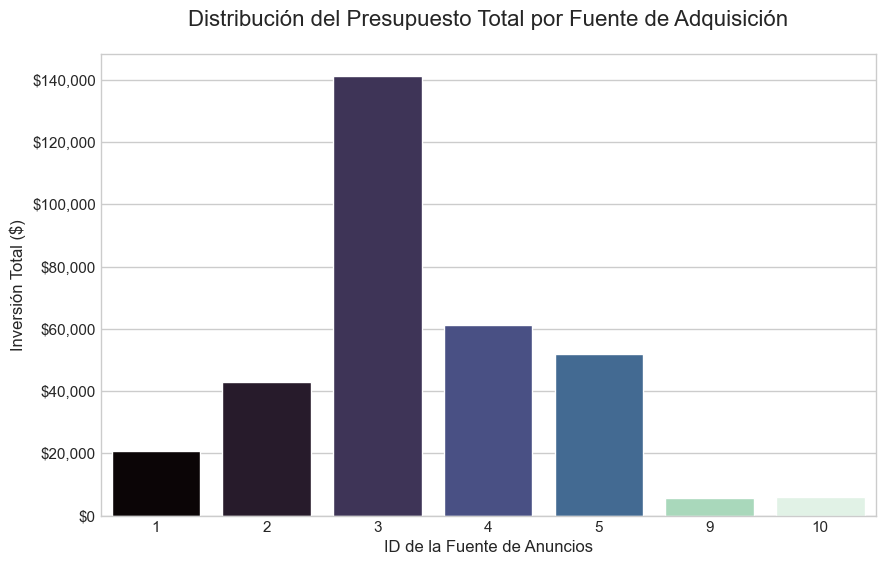

In [88]:
# --- Análisis de Costos: Inversión por Fuente ---
# Visualización de la distribución del presupuesto para compararla posteriormente con el retorno
plt.figure(figsize=(10, 6))
sns.barplot(
    x=spend_by_source.index, 
    y=spend_by_source.values, 
    hue=spend_by_source.index, 
    palette='mako',
    legend=False
)
plt.title('Distribución del Presupuesto Total por Fuente de Adquisición', pad=20)
plt.xlabel('ID de la Fuente de Anuncios')
plt.ylabel('Inversión Total ($)')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.show()

### 📈 Interpretación: Concentración de Capital
* **Canal Dominante:** La **Fuente 3** recibe la mayor parte de la inversión (superando los **$140,000**), seguida por la Fuente 4 y 5.
* **Apuestas Menores:** Las fuentes 9 y 10 tienen presupuestos marginales. El éxito del proyecto dependerá de si la Fuente 3 está justificando este nivel masivo de gasto.

### 🏷️ 3. Dinámica del CAC Mensual: Costo de Adquisición
El **CAC** nos dice cuánto nos cuesta "comprar" un cliente en cada canal. Buscamos canales con CAC bajo o estable que permitan escalar el negocio sin quemar capital innecesariamente.

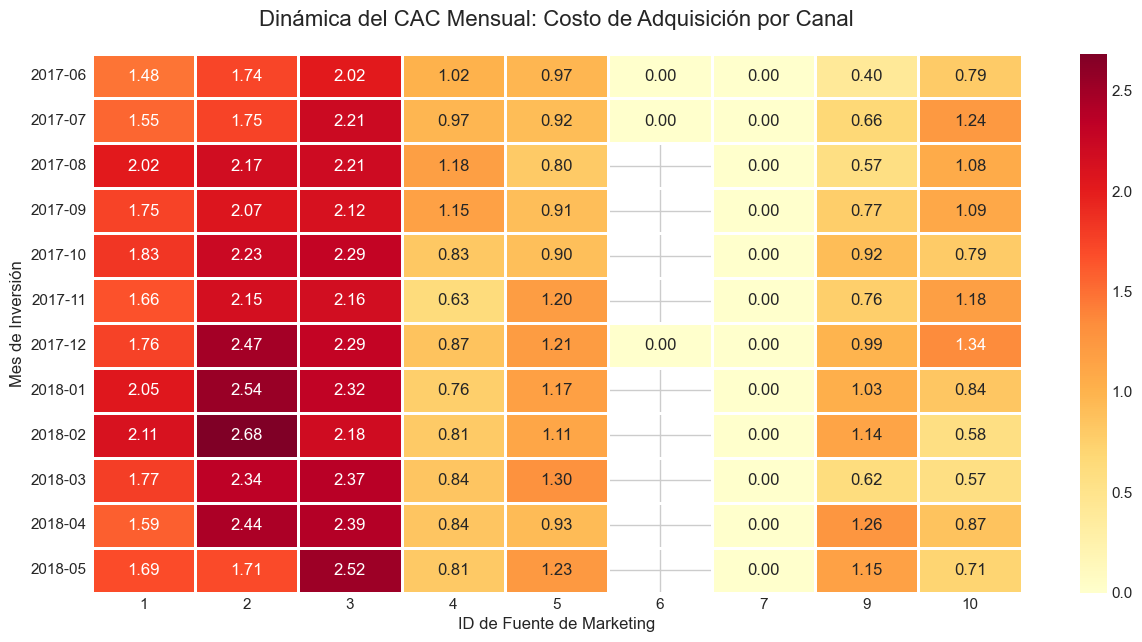

In [89]:
# --- Eficiencia de Adquisición: CAC Mensual por Fuente ---
plt.figure(figsize=(15, 7))
sns.heatmap(
    cac_by_month_source, 
    annot=True, 
    fmt='.2f', 
    cmap="YlOrRd", 
    linewidths=1
)
plt.title('Dinámica del CAC Mensual: Costo de Adquisición por Canal', fontsize=16, pad=20)
plt.xlabel('ID de Fuente de Marketing')
plt.ylabel('Mes de Inversión')
plt.show()

### 📈 Interpretación: Eficiencia de Adquisición
* **Canales Costosos:** La **Fuente 3** no solo es la que más gasta, sino que mantiene un CAC elevado (entre **$2.02 y $2.52**). 
* **Oportunidades de Eficiencia:** La **Fuente 1** y la **Fuente 2** presentan costos de adquisición más competitivos. La gran pregunta es si estos clientes "baratos" generan suficiente LTV para compensar.

### 🎯 4. El Indicador Definitivo: ROMI por Canal
Cruzamos el LTV contra el CAC. Si el **ROMI es > 1**, el canal es rentable. Si es **< 1**, estamos perdiendo dinero por cada cliente adquirido. La línea roja marca el umbral de supervivencia financiera.

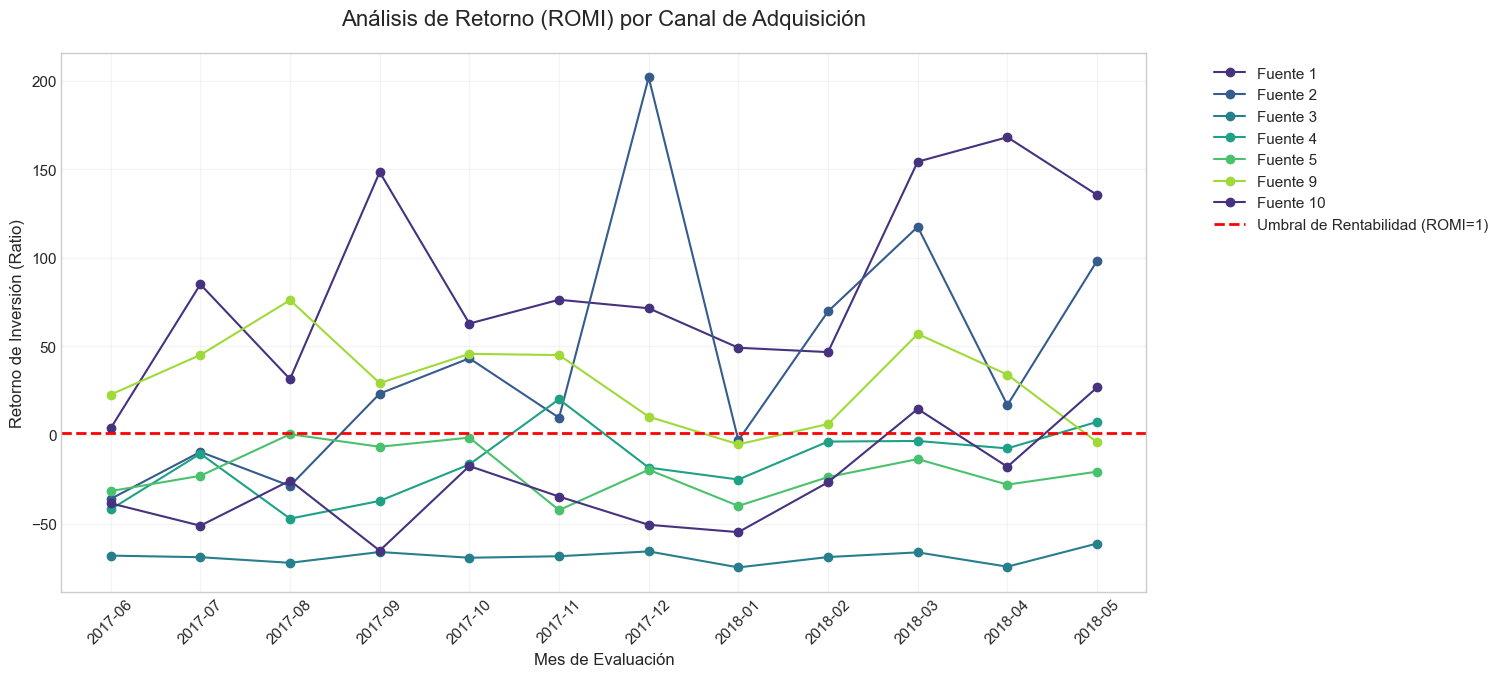

In [90]:
# --- El Indicador Definitivo: ROMI por Canal ---
plt.figure(figsize=(14, 7))
for source in romi_by_month_source.columns:
    plt.plot(romi_by_month_source.index.astype(str), romi_by_month_source[source], marker='o', label=f'Fuente {source}')

plt.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Umbral de Rentabilidad (ROMI=1)')
plt.title('Análisis de Retorno (ROMI) por Canal de Adquisición', fontsize=16, pad=20)
plt.xlabel('Mes de Evaluación')
plt.ylabel('Retorno de Inversión (Ratio)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(alpha=0.2)
plt.show()

### 📈 Interpretación: Rentabilidad Real y Decisión Estratégica
* **Destrucción de Valor:** La **Fuente 3** (donde más invertimos) se mantiene sistemáticamente **por debajo del umbral de rentabilidad**. Estamos perdiendo dinero en nuestro canal principal.
* **Estrellas de Rentabilidad:** La **Fuente 1** y la **Fuente 2** muestran picos de retorno extraordinarios, recuperando la inversión con creces. 
* **Veredicto:** Es imperativo **reasignar presupuesto** de la Fuente 3 hacia las Fuentes 1 y 2 para optimizar la rentabilidad global de **Showz**.

---
**Siguiente Paso:** Con este diagnóstico financiero, procederemos a la **Fase 5: Conclusiones**, donde formalizaremos la estrategia de reasignación presupuestaria.

## 📱 Fase 5: Device Analytics - Diagnóstico de Plataforma

No todos los puntos de contacto tienen el mismo valor. En esta fase, desglosamos el rendimiento de **Showz** según el dispositivo de acceso (**Desktop vs. Touch**). El objetivo es identificar si existe una brecha de conversión entre plataformas que deba ser atendida por el equipo de Producto o UX.

### 🔍 Objetivos del Diagnóstico:
1.  **Auditoría de Alcance:** Determinar qué plataforma domina el tráfico de usuarios únicos.
2.  **Análisis de Valor:** Contrastar el volumen de usuarios contra el ingreso real generado para identificar la rentabilidad por dispositivo.

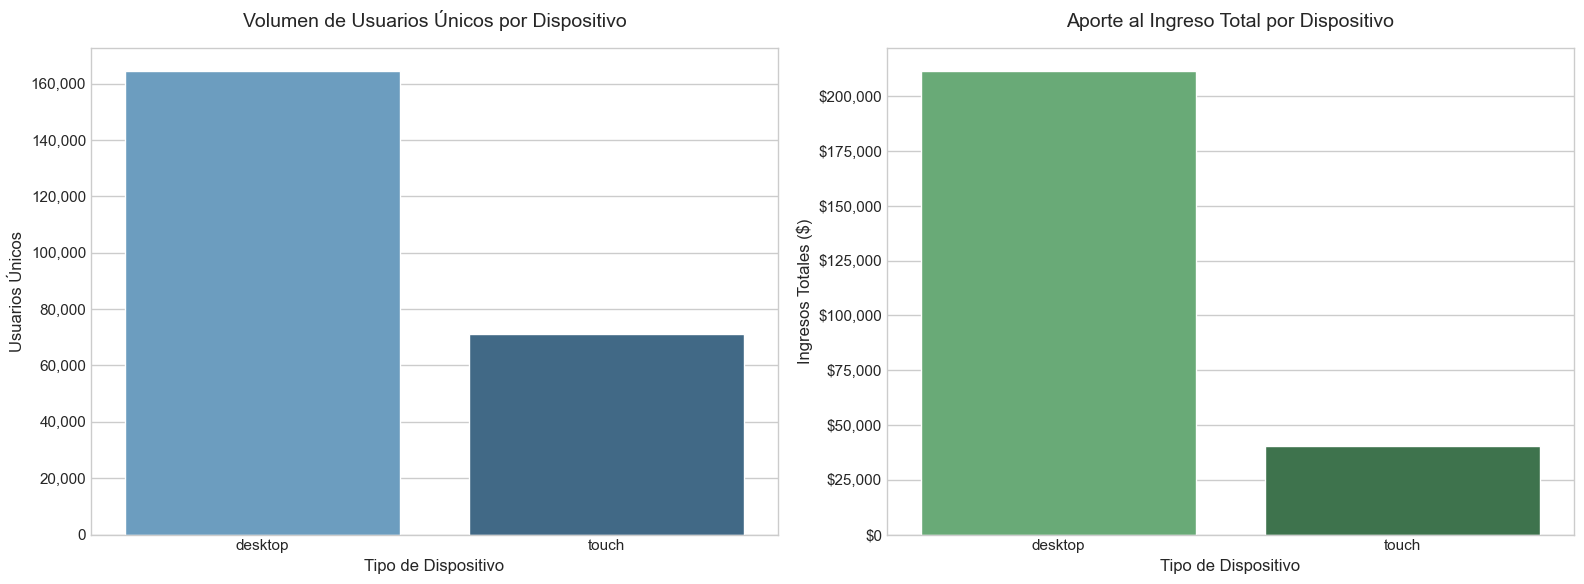

In [91]:
# --- Diagnóstico de Plataforma: Usuarios vs Ingresos (Código corregido sin Warnings) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Volumen: Alcance por Dispositivo
sns.barplot(
    x=users_by_device.index, 
    y=users_by_device.values, 
    hue=users_by_device.index, # Solución al FutureWarning
    palette='Blues_d', 
    ax=ax1,
    legend=False
)
ax1.set_title('Volumen de Usuarios Únicos por Dispositivo', fontsize=14, pad=15)
ax1.set_xlabel('Tipo de Dispositivo')
ax1.set_ylabel('Usuarios Únicos')
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Gráfico de Valor: Aporte al Ingreso por Dispositivo
sns.barplot(
    x=revenue_by_device.index, 
    y=revenue_by_device.values, 
    hue=revenue_by_device.index, # Solución al FutureWarning
    palette='Greens_d', 
    ax=ax2,
    legend=False
)
ax2.set_title('Aporte al Ingreso Total por Dispositivo', fontsize=14, pad=15)
ax2.set_xlabel('Tipo de Dispositivo')
ax2.set_ylabel('Ingresos Totales ($)')
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
plt.show()

### 📈 Interpretación: La Supremacía de Desktop en la Generación de Valor

El diagnóstico comparativo arroja una realidad estratégica clara sobre el comportamiento de compra en la plataforma:

* **Dominio en Volumen y Valor:** Los dispositivos **Desktop** no solo atraen al mayor número de usuarios únicos (superando los 160,000), sino que son responsables de la gran mayoría del ingreso total (más de **$200,000 USD**).
* **Eficiencia de Conversión:** Aunque existe un volumen considerable de usuarios en dispositivos **Touch**, su aporte al ingreso es desproporcionadamente bajo en comparación con Desktop. Esto sugiere que los usuarios prefieren la interfaz de escritorio para finalizar transacciones complejas o que la experiencia móvil (Touch) presenta fricciones en el proceso de pago.

**💡 Recomendación Estratégica:**
Priorizar la optimización del embudo de ventas en **Desktop** para proteger el flujo de caja actual, mientras se realiza una auditoría de UX en la versión **Touch** para capturar el potencial de ingresos de los más de 60,000 usuarios que utilizan dispositivos móviles pero no están convirtiendo al mismo ritmo.

---
**Siguiente Paso:** Con este panorama completo, procederemos a la **Fase 06: Strategic Outlook**, integrando todos los hallazgos para la toma de decisiones finales.

# 🏁 Fase 06: Strategic Outlook - Conclusiones y Roadmap de Inversión

Tras auditar las dimensiones de **Producto, Ventas, Marketing y Plataforma**, hemos consolidado el diagnóstico final de **Showz**. El éxito de la compañía no depende de atraer más tráfico, sino de **calibrar la calidad de la adquisición** y optimizar la experiencia transaccional.

---

## 📊 6.1 Diagnóstico de Rentabilidad (Unit Economics)
El análisis cruzado de LTV y CAC revela que la rentabilidad está concentrada en nichos específicos, mientras que el gasto masivo se está diluyendo en canales ineficientes.

| Canal (Source ID) | Eficiencia (CAC) | Rentabilidad (ROMI) | Estatus Estratégico |
| :--- | :--- | :--- | :--- |
| **Source 1** | Alto | **+86.1%** | 🚀 **Escalar Inversión** |
| **Source 2** | Alto | **+41.9%** | ✅ **Mantener y Optimizar** |
| **Source 9 & 4** | **Bajo (Eficaz)** | -5.3% a -15.3% | ⚠️ **Revisar Calidad de Lead** |
| **Source 3** | Alto (Ineficiente) | **-68.0%** | 🛑 **Pausa / Reestructuración** |

---

## 💡 6.2 Hallazgos Transversales (Insights Clave)

1.  **La Paradoja de la Adquisición:** Las fuentes **9 y 4** son excelentes "atrayendo" volumen (CAC < $0.90), pero atraen usuarios con bajo poder de compra o nula recurrencia. En contraste, las fuentes **1 y 2** son costosas, pero capturan clientes de alto valor que multiplican la inversión.
2.  **La Ventana de Oro (24h):** El comportamiento de compra es puramente **impulsivo o reactivo**. La inmensa mayoría de las conversiones ocurren el mismo día de la primera visita. Si no se cierra la venta en 48 horas, el usuario se pierde.
3.  **Brecha de Plataforma (Desktop vs. Touch):** Existe una fuga de ingresos en dispositivos móviles. Aunque el volumen de usuarios en **Touch** es significativo, el **90% de los ingresos** proviene de **Desktop**. Esto sugiere fricciones críticas en el checkout móvil.
4.  **Fuga de Capital en Fuente 3:** Es el canal donde más presupuesto se asigna y donde el retorno es más pobre (-68%). Es la principal causa del déficit en el ROMI global.


---

## 🚀 6.3 Plan de Acción: Estrategia de Reasignación de Capital

### 🟢 A. Maximización de Retorno (Sources 1 y 2)
* **Acción:** Reasignar el **30% del presupuesto actual de la Fuente 3** hacia la **Fuente 1**.
* **Justificación:** El LTV de estas fuentes es el único que supera el umbral de rentabilidad a largo plazo.

### 🟡 B. Optimización de Producto y UX (Estrategia Touch)
* **Acción:** Iniciar una auditoría de **UX/UI en la versión móvil**.
* **Objetivo:** Reducir la brecha de conversión. Si logramos que el usuario "Touch" convierta al 50% del ritmo de Desktop, los ingresos totales crecerían un ~20% sin aumentar el gasto en anuncios.

### 🔴 C. Mitigación de Pérdidas (Source 3)
* **Acción:** Reducción inmediata del 50% del gasto en este canal y auditoría de la segmentación de anuncios.
* **Riesgo:** Mantener este nivel de inversión sin ajustes compromete la viabilidad operativa de la empresa.

---




# 🚀 Resumen Ejecutivo: Diagnóstico de Rentabilidad y Visión Estratégica

**Showz** presenta un ecosistema con una tracción inicial sólida, pero enfrenta desafíos críticos en la eficiencia de su gasto publicitario. Tras auditar integralmente la operación, el diagnóstico se resume en los siguientes pilares:

* **Dinámica de Conversión:** La plataforma opera bajo un modelo de **alta intención e inmediatez**. La mayoría de los usuarios convierten en el **Día 0**, lo que indica que el inventario de eventos es el principal motor de decisión.
* **Crisis de Eficiencia en Marketing:** El canal con mayor inversión (**Fuente 3**) presenta un **ROMI negativo del -68%**, lo que representa una destrucción activa de valor. Por el contrario, las **Fuentes 1 y 2** son los motores de rentabilidad real, con retornos que superan el **80%**.
* **Fuga de Ingresos por Dispositivo:** Existe una dependencia crítica de **Desktop** (90% de los ingresos). A pesar del volumen de usuarios en dispositivos **Touch**, su baja tasa de conversión sugiere fricciones técnicas o de experiencia de usuario en el flujo móvil.

### 💡 Veredicto y Recomendación Final
Para maximizar el valor de la compañía, se debe **ejecutar una reasignación presupuestaria inmediata**, moviendo el capital de la Fuente 3 hacia la Fuente 1. Asimismo, es imperativo priorizar la **optimización del embudo de ventas en dispositivos Touch**. Sin estos ajustes, el crecimiento de Showz seguirá viéndose comprometido por costos de adquisición ineficientes y puntos de fuga en la experiencia de usuario.